<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/models/logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
traindata = pd.read_csv('train (2).csv', index_col=0)
testdata = pd.read_csv('test (2).csv', index_col=0)
data = pd.concat([traindata, testdata], axis=0)

In [3]:
def baseline_eda(data):
  df = data.copy()
  list_gate_vars = ['gate_'+str(i) for i in sorted(list(df['gate_id'].unique()))]
  new_vals = pd.get_dummies(df['gate_id']).values
  df[list_gate_vars] = new_vals
  df['ts'] = pd.to_datetime(df['ts'])
  list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  df[list_dow] = pd.get_dummies(df['ts'].dt.day_name())[list_dow].values
  df['hour'] = df['ts'].dt.hour.values
  list_hours = ['hour_'+str(i) for i in sorted(list(df['ts'].dt.hour.unique()))]
  df[list_hours] = pd.get_dummies(df['ts'].dt.hour.values).values
  df['min'] = df['ts'].dt.minute.values
  df['day'] = df['ts'].dt.day.values
  df['month'] = df['ts'].dt.month.values
  df['dayofweek'] = df['ts'].dt.dayofweek.values
  return df

### Preprocessing

In [4]:
def get_daytime(hour):
  if hour < 6:
    return 0 # night
  elif hour < 11:
    return 1 # morning
  elif hour < 18:
    return 2 #afternoon
  else:
    return 3 #evening

def get_season(month):
  months = {12:0, 1:0, 2:0,
            3:1, 4:1, 5:1,
            6:2, 7:2, 8:2,
            9:3, 10:3, 11:3}
  return months[month]

def is_weekend(day_of_week):
  return day_of_week > 5

def is_holiday(pass_count, is_weekend, q25):
    if not is_weekend and pass_count < q25:
        return True
    return False

def is_working_weekend(pass_count, is_weekend, q75):
    if is_weekend and pass_count > q75:
        return True
    return False


def data_processing(df):
  df = df.copy()
  df['date'] = pd.to_datetime(df["ts"])
  df.drop(['ts'], axis=1, inplace=True)

  # basic
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['hour'] = df['date'].dt.hour
  df['minute'] = df['date'].dt.minute
  df['second'] = df['date'].dt.second

  # specific
  df['season'] = df['month'].apply(get_season)
  df['weekday'] = df['date'].dt.dayofweek + 1
  df['daytime'] = df['hour'].apply(get_daytime)
  df['weekend'] = df['weekday'].apply(is_weekend)

  # sophisticated
  list_hours = ['hour_'+str(i) for i in sorted(list(df['date'].dt.hour.unique()))]
  df[list_hours] = pd.get_dummies(df['date'].dt.hour.values).values
  list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  df[list_dow] = pd.get_dummies(df['date'].dt.day_name())[list_dow].values

  df["gate_daily_used"] = df.groupby(['month', 'day', 'gate_id']).transform("size")
  df['inter_time_pass'] = df.groupby('gate_id')['date'].diff().dt.total_seconds().fillna(0)
  df['timedelta_pass'] = df['date'].diff().dt.total_seconds().fillna(0)

  #encode
  df = pd.get_dummies(df, columns=['gate_id'])

  return df


def extra_baseline(df):
  df["gate_daily_used"] = df.groupby(['month', 'day', 'gate_id']).transform("size")
  df['inter_time_pass'] = df.groupby('gate_id')['ts'].diff().dt.total_seconds().fillna(0)
  df['timedelta_pass'] = df['ts'].diff().dt.total_seconds().fillna(0)
  df['season'] = df['month'].apply(get_season)
  df['daytime'] = df['hour'].apply(get_daytime)
  df['weekday'] = df['ts'].dt.dayofweek + 1
  df['weekend'] = df['weekday'].apply(is_weekend)
  return df

### Evaluation

In [5]:
def make_dict(feature):
  dict_val = dict()
  inverse_dict_val = dict()

  ilist = list(feature.unique())
  for i in range(len(ilist)):
    dict_val[ilist[i]] = f'user_'+str(i)
    inverse_dict_val[f'user_'+str(i)] = int(ilist[i])

  word = feature.copy()
  for userid in ilist:
    word.loc[feature == userid] = dict_val[userid]
  return inverse_dict_val, word

def table_outputs(names, reals, preds):
  words = pd.DataFrame()
  words['user_word'] = names
  words['true'] = reals
  words['preds'] = preds
  return words

def groupby_userword(dfn):
  return pd.DataFrame(dfn.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

def get_freq_df(dfn, inverse_dict):
  comp_df = groupby_userword(dfn)
  for idx in comp_df.index:
    comp_df.loc[idx, 'true'] = inverse_dict[idx]
  comp_df = comp_df.astype(int)
  comp_df['comp'] = comp_df['preds'] == comp_df['true']
  comp_df['norm'] = 1
  get_guesses(comp_df)
  return comp_df

def print_accuracy(real, predicted):
  print(f'Accuracy: {round(accuracy_score(real, predicted)*100 ,2)}%')

def get_guesses(dfn):
  true_answers = (dfn['comp'] * dfn['norm']).sum()
  total_answers = dfn['norm'].sum()
  precent_true = round((true_answers/total_answers)*100, 1)
  print(f'Result: {true_answers}/{total_answers}  {precent_true}%\n')

def guessed_right(real, predicted):
  print_accuracy(real, predicted)
  inverse_user_dict, word = make_dict(real)
  words = table_outputs(word, real, predicted)
  comp_df = get_freq_df(words, inverse_user_dict)
  return groupby_userword(words)

### Split

In [6]:
def custom_train_test_split(df, cols_cat):
  train_idx = df['user_word'].isnull()
  train = df.loc[train_idx]
  test = df.loc[~train_idx]
  X = train.copy()
  y = X['user_id'].astype(int)
  X_test = test.copy()

  X = X[cols_cat].astype(int)
  X_test = X_test[cols_cat].astype(int)
  return X, y, X_test

### Scale

In [7]:
def scale(df):
  scaler = StandardScaler()
  scaled = scaler.fit_transform(df)
  return scaled

def train_test_scale(train, test):
  scaled_train = scale(train)
  scaled_test = scale(test)
  return scaled_train, scaled_test

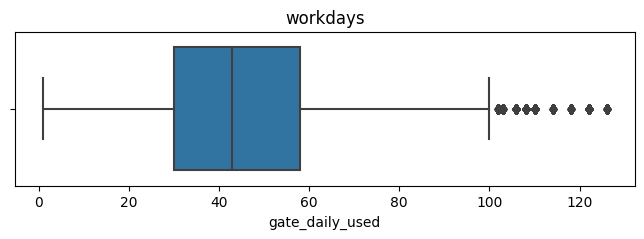

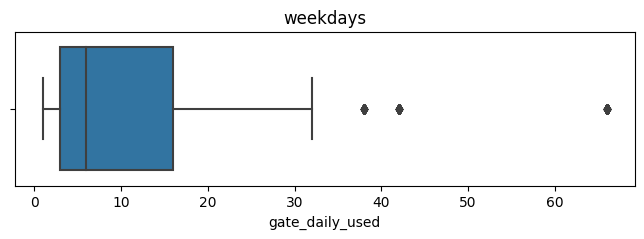

In [107]:
daykind = ('workdays', 'weekdays')
for weekend in range(len(daykind)):
  weekend_use = df[df["weekend"] == weekend].gate_daily_used
  plt.figure(figsize=(8,2))
  plt.title(daykind[weekend])
  sns.boxplot(x='gate_daily_used', data=df[df["weekend"] == weekend])

### Baseline

In [58]:
#baseline solution
df = baseline_eda(data)
df = extra_baseline(df)
df = df.drop('weekday', axis=1)
val_index = traindata['ts'] > '2022-11-30'
train_idx = df['user_word'].isnull()
train = df.loc[train_idx]
test = df.loc[~train_idx]

X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)
cols_cat = list(df.columns[4:])
X = X[cols_cat].astype(int)
X_val = X_val[cols_cat].astype(int)

### Custom solution

In [11]:
#for custom solution
df = data_processing(data)
train_df = df[df['user_word'].isna()].drop(['user_word'], axis=1)

# Get test X and ultimate y
test_labels = df[df['user_id'].isna()]['user_word']
test_df = df[df['user_id'].isna()].drop(['user_id', 'user_word'], axis=1)

# get train X and y
X = train_df.drop('user_id', axis=1)
y = train_df['user_id']

cols_cat = df.columns[4:]

val_index = traindata['ts'] > '2022-11-30'
train_idx = df['user_word'].isnull()
train = df.loc[train_idx]
test = df.loc[~train_idx]
X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)

X = X[cols_cat].astype(int)
X_val = X_val[cols_cat].astype(int)


### Scaling data

In [9]:
scaler_X = StandardScaler()
scaler_X_val = StandardScaler()

scaler_X.fit(X)
scaler_X_val.fit(X_val)

X_scaled = scaler_X.transform(X)
X_val_scaled = scaler_X_val.transform(X_val)

### Check on the train/val

In [24]:
clf = LogisticRegression(random_state=1, solver='lbfgs', C=1, penalty='l2', max_iter=2000).fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
y_val_pred = clf.predict(X_val_scaled)

### Make baseline dict

In [11]:
def get_train_score(y_val, y, y_val_pred):
  user_dict_val = dict()
  inverse_user_dict_val = dict()

  y_val_list = list(y_val.unique())
  for i in range(len(y_val_list)):
      user_dict_val[y_val_list[i]] = 'user_'+str(i)
      inverse_user_dict_val['user_'+str(i)] = y_val_list[i]


  user_dict_train = dict()
  inverse_user_dict_train = dict()

  y_train_list = list(y.unique())
  for i in range(len(y_train_list)):
      user_dict_train[y_train_list[i]] = 'train_user_'+str(i)
      inverse_user_dict_train['train_user_'+str(i)] = y_train_list[i]


  y_val_word = y_val.copy()

  for y_val_id in y_val_list:
      y_val_word.loc[y_val == y_val_id] = user_dict_val[y_val_id]

  y_word = y.copy()

  for y_train_id in y_train_list:
      y_word.loc[y == y_train_id] = user_dict_train[y_train_id]


  val_words = pd.DataFrame()

  val_words['word'] = y_val_word
  val_words['true'] = y_val
  val_words['preds'] = y_val_pred

  train_words = pd.DataFrame()

  train_words['word'] = y_word
  train_words['true'] = y
  train_words['preds'] = y_pred

  comp_df = pd.DataFrame(val_words.groupby('word')['preds'].agg(lambda x: x.value_counts().index[0]))
  comp_df_train = pd.DataFrame(train_words.groupby('word')['preds'].agg(lambda x: x.value_counts().index[0]))
  for idx in comp_df.index:
    comp_df.loc[idx, 'true'] = inverse_user_dict_val[idx]

  comp_df = comp_df.astype(int)

  for idx in comp_df_train.index:
      comp_df_train.loc[idx, 'true'] = inverse_user_dict_train[idx]

  comp_df_train = comp_df_train.astype(int)
  comp_df['comp'] = comp_df['preds'] == comp_df['true']

  comp_df_train['comp'] = comp_df_train['preds'] == comp_df_train['true']
  comp_df['norm'] = 1
  comp_df_train['norm'] = 1
  true_answers = (comp_df['comp'] * comp_df['norm']).sum()
  total_answers = comp_df['norm'].sum()
  precent_true = round((true_answers/total_answers)*100, 1)
  print('Оценка val', true_answers, total_answers, precent_true)
  true_answers_train = (comp_df_train['comp'] * comp_df_train['norm']).sum()
  total_answers_train = comp_df_train['norm'].sum()
  precent_true_train = round((true_answers_train/total_answers_train)*100, 1)
  print('Оценка train', true_answers_train, total_answers_train, precent_true_train)


In [25]:
guessed_right(y, y_pred)
guessed_right(y_val, y_val_pred)

Accuracy: 17.4%
Result: 23/50  46.0%

Accuracy: 10.08%
Result: 6/43  14.0%



,preds
user_word,
user_0,1
user_1,12
user_10,55
user_11,42
user_12,42
user_13,42
user_14,12
user_15,12
user_16,12


### Check on real values

In [59]:
X = train.copy()
y = X['user_id'].astype(int)
X_test = test.copy()
X = X[cols_cat].astype(int)
X_test = X_test[cols_cat].astype(int)

scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X.fit(X)
scaler_X_test.fit(X_test)

X_scaled = scaler_X.transform(X)
X_test_scaled = scaler_X_test.transform(X_test)


In [60]:
clf = LogisticRegression(random_state=42, solver='saga', C=0.01, penalty='l2',  max_iter=2000).fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
y_test_pred = clf.predict(X_test_scaled)

In [62]:
test_words = pd.DataFrame()
test_words['user_word'] = test['user_word']
test_words['preds'] = y_test_pred
comp_df_test = pd.DataFrame(test_words.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))
comp_df_test.to_csv('answer.csv')

In [64]:
comp_df_test

,preds
user_word,
aucroc,12
binary,12
blue,55
categorical,14
coefficient,15
collinear,12
distributed,55
epsilon,1
f1,37


### Custom code gridsearch real vals

In [12]:
X, y, X_test = custom_train_test_split(df, df.columns[4:])
X_scaled, X_test_scaled = train_test_scale(X, X_test)

In [ ]:
model = LogisticRegression(max_iter=100, solver= 'saga')
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': [None, 'elasticnet', 'l1', 'l2']}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_scaled, y)
print('Best parameters:\n', grid_search.best_params_)
print('Best score:\n', grid_search.best_score_)

In [ ]:
model1 = LogisticRegression(max_iter=1000)
param_grid1 = {'C': [0.01],
              'solver': ['newton-cg', 'lbfgs', 'sag'],
              'penalty': ['l2']}
grid_search1 = GridSearchCV(model1, param_grid1, cv=5)
grid_search1.fit(X_scaled, y)
print('Best parameters:\n', grid_search1.best_params_)
print('Best score:\n', grid_search1.best_score_)

In [ ]:
mod = LogisticRegression()
mod.fit(X_scaled, y)
modresult = guessed_right(y, mod.predict(X_scaled))

In [ ]:
modresult

In [ ]:
preds = mod.predict(X_test_scaled)
test_words = pd.DataFrame()
test_words['user_word'] = test['user_word']
test_words['preds'] = preds

test_result = pd.DataFrame(test_words.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

test_result#.to_csv('answer.csv')

In [ ]:
result = guessed_right(y, mod.predict(X_scaled))

In [250]:
result.to_csv('answer.csv')